# AuraFlow v0.3

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/notebooks/blob/main/notebooks/auraflow.ipynb)

[AuraFlow](https://blog.fal.ai/auraflow/) is an open-source (Apache 2), flow-based, multi-modal diffusion transformer (MMDiT) model from [Fal.ai](https://fal.ai). It uses the [pile-t5-xl](https://huggingface.co/EleutherAI/pile-t5-xl) text encoder from [EleutherAI](https://www.eleuther.ai).

In [1]:
# @title Install
import os
import sys
import subprocess
from importlib.util import find_spec

modules = ["diffusers", "hf_transfer"]
if not all(find_spec(module) for module in modules):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *modules])
    os.kill(os.getpid(), 9)

In [2]:
# @title Imports
import gc
import os
from datetime import datetime
from hashlib import md5
from io import BytesIO
from warnings import filterwarnings

import torch
from PIL import Image
from diffusers import AuraFlowPipeline, FlowMatchEulerDiscreteScheduler, FlowMatchHeunDiscreteScheduler
from transformers import logging

In [3]:
# @title Environment
try:
    from google.colab import userdata

    HF_TOKEN = userdata.get("HF_TOKEN")
except ImportError:
    HF_TOKEN = os.environ.get("_HF_TOKEN", None) or os.environ.get("HF_TOKEN", "")
finally:
    os.environ["HF_TOKEN"] = HF_TOKEN
    os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

filterwarnings("ignore", category=FutureWarning, module="diffusers")
filterwarnings("ignore", category=FutureWarning, module="transformers")
logging.set_verbosity_error()

In [4]:
# @title Pipeline
class Loader:
    _instance = None

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
            cls._instance.pipe = None
        return cls._instance

    def _flush(self):
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

    def _load_pipeline(self, cpu_offload, **kwargs):
        if self.pipe is None:
            try:
                print("Loading fal/AuraFlow-v0.3...")
                self.pipe = AuraFlowPipeline.from_pretrained("fal/AuraFlow-v0.3", **kwargs)
                if cpu_offload:
                    self.pipe.enable_model_cpu_offload()
                else:
                    self.pipe.to("cuda")
            except Exception as e:
                print(e)
                self.pipe = None

    def load(self, scheduler, cpu_offload):
        schedulers = {
            "Euler": FlowMatchEulerDiscreteScheduler,
            "Heun": FlowMatchHeunDiscreteScheduler,
        }
        scheduler_kwargs = {"shift": 3.0}
        pipe_kwargs = {
            "variant": "fp16",
            "torch_dtype": torch.float16,
            "scheduler": schedulers[scheduler](**scheduler_kwargs),
        }
        self._load_pipeline(cpu_offload, **pipe_kwargs)

        # error
        if self.pipe is None:
            return

        same_scheduler = isinstance(self.pipe.scheduler, schedulers[scheduler])
        if not same_scheduler:
            print(f"Switching to {scheduler}...")
            self.pipe.scheduler = schedulers[scheduler](**scheduler_kwargs)

In [5]:
# @title Inference
def main():
    global \
        SCHEDULER, \
        PROMPT, \
        NEGATIVE_PROMPT, \
        SEED, \
        OUT_DIR, \
        WIDTH, \
        HEIGHT, \
        GUIDANCE_SCALE, \
        INFERENCE_STEPS, \
        CPU_OFFLOAD

    if not torch.cuda.is_available():
        raise RuntimeError("CUDA not available")

    if SEED is None or SEED < 0:
        seed = int(datetime.now().timestamp() * 1e6) % 2**64
    else:
        seed = SEED

    loader = Loader()
    loader.load(SCHEDULER, CPU_OFFLOAD)

    if loader.pipe is None:
        return

    pipe = loader.pipe

    try:
        image = pipe(
            width=WIDTH,
            height=HEIGHT,
            prompt=PROMPT,
            negative_prompt=NEGATIVE_PROMPT,
            guidance_scale=GUIDANCE_SCALE,
            num_inference_steps=INFERENCE_STEPS,
            generator=torch.Generator(device=pipe.device).manual_seed(seed),
        ).images[0]
    except Exception as e:
        print(e)
        return

    image_file = save_image(image, OUT_DIR)
    print(image_file)
    display(Image.open(image_file))


# save image using content-based hash
def save_image(image, out_dir="."):
    image_bytes = BytesIO()
    image.save(image_bytes, format="PNG")
    image_bytes.seek(0)
    image_hash = md5(image_bytes.read()).hexdigest()
    filename = f"{out_dir}/{image_hash}.png"
    image.save(filename)
    return filename

/content/9084ed4721828392970987e613ec8342.png


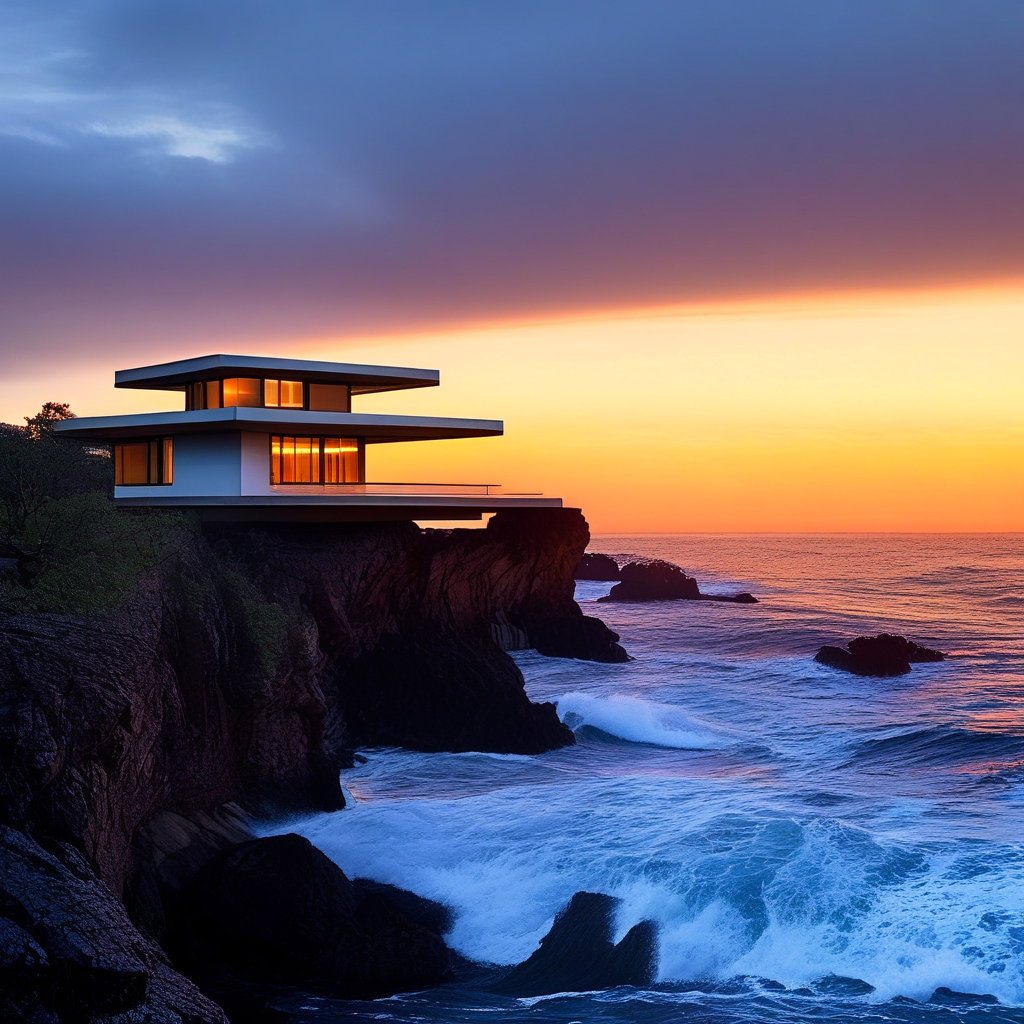

In [6]:
# fmt: off
SCHEDULER = "Euler"  # @param {type: "string"} ["Euler", "Heun"]
PROMPT = "A solitary house on a cliff. Mid-century Frank Lloyd Wright architecture. Waves crashing against the rocks below. Late-evening sunset. Dramatic lighting. Ultra-high resolution photography."  # @param {type: "string"}
NEGATIVE_PROMPT = "ugly"  # @param {type: "string"}
SEED = 644447295926805  # @param {type: "integer", min: -1, max: 18446744073709551615}
OUT_DIR = "."  # @param {type: "string"}
WIDTH = 1024  # @param {type: "slider", min: 768, max: 1536, step: 64}
HEIGHT = 1024  # @param {type: "slider", min: 768, max: 1536, step: 64}
GUIDANCE_SCALE = 4.5  # @param {type: "slider", min: 0, max: 15, step: 0.1}
INFERENCE_STEPS = 35  # @param {type: "slider", min: 1, max: 50}
CPU_OFFLOAD = False  # @param {type: "boolean"}
main()